In [ ]:
!pip install transformers

In [ ]:
import pickle
import pandas as pd
import numpy as np
import csv
import time
import torch
from torchtext.legacy import data 
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import torch.nn as nn
from transformers import BertConfig, BertTokenizer, BertForSequenceClassification

## import data from drive
## this should be changed depending the address for you
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
# os.chdir('/content/drive/MyDrive/LTP - myside/')
os.chdir('/content/drive/MyDrive/LCT/Language Technology Project/LTP Project') 

## using cuda if available
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

def read_pickle_file(filename):
    with open(filename, 'rb') as f:
        x = pickle.load(f)

    return x
X_train = read_pickle_file("./data/X_train.pickle")
X_test = read_pickle_file("./data/X_test.pickle")
y_train = read_pickle_file("./data/y_train.pickle")
y_test = read_pickle_file("./data/y_test.pickle")


#Reproducing same results
SEED = 2019

#Torch
torch.manual_seed(SEED)

d = {'text':X_train,'label':y_train}
train_df = pd.DataFrame(d)
train_df = train_df.sample(frac = 1, random_state=SEED)
print(train_df)
train_df.to_csv(r'train.csv')

In [ ]:
print(type(X_train[0]))
print(type(y_train[0]))

In [ ]:
with open('train.csv', 'r') as file:
    reader = csv.reader(file)
    row_count = sum(1 for row in reader)
    print(row_count)


X_train = []
y_train = []
X_eval = []
y_eval = []

with open('train.csv', 'r') as file:
    reader = csv.reader(file)
    row_num = 0
    for row in reader:
      # print(row_num)
      if row_num == 0:
        print(f'Column names are {", ".join(row)}')
      elif row_num < 0.8*row_count:
        X_train.append(row[1])
        y_train.append(int(row[2]))
      else:
        X_eval.append(row[1])
        y_eval.append(int(row[2]))
      row_num += 1
        

In [ ]:
print(type(X_train[0]))
print(type(y_train[0]))
print(X_train)
print(y_train)

print(X_train[0])
print(y_train[0])

In [ ]:
print(type(X_eval[0]))
print(type(y_eval[0]))
print(X_eval)
print(y_eval)

print(X_eval[0])
print(y_eval[0])

In [ ]:
class HumorDataset(Dataset):
  def __init__(self, text_data, input_labels, tokenizer):
        super().__init__()
        
        data = []
        labels = []
        ## to be changed if needed
        ## to be changed if needed
        # max_length = 217 # for bert_base_cased
        max_length = 207
        self.max_length = max_length

        for i, sample in enumerate(text_data):
          tokens = tokenizer.tokenize(sample)
          data_idxs = tokenizer.encode(sample)
          
          padded = np.zeros(max_length)
          # if max_length < 217: # for bert_base_cased
          if max_length < 207:
            padded = data_idxs[:max_length]
          else:
            padded[:len(data_idxs)] = data_idxs
          
          data.append(padded)
          
          labels.append(input_labels[i])
          
        self.data = torch.tensor(data, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

  def __getitem__(self, index):
        return self.data[index], self.labels[index]

  def __len__(self):
        return len(self.data)


In [ ]:
## to be changed
pretrained = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained)
tokenizer.do_basic_tokenize = False


In [ ]:
#set batch size
BATCH_SIZE = 64

In [ ]:
train_dataset = HumorDataset(X_train, y_train, tokenizer)

In [ ]:
train_loader = DataLoader(train_dataset,
        shuffle=True,
        batch_size=BATCH_SIZE)


In [ ]:
# Configure model parameters
config = BertConfig.from_pretrained(pretrained)
config.num_labels = 2
config.num_hidden_layers = 1
config.num_attention_heads = 1
config.output_attentions = True

## to be changed
model = BertForSequenceClassification.from_pretrained(
    pretrained,
    num_labels=2,
    num_hidden_layers=1,
    num_attention_heads=1,
    output_attentions=True)

In [ ]:
#architecture
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')


In [ ]:
#define optimizer and loss
# optimizer = optim.Adam(model.parameters())
optimizer = optim.SGD(model.parameters(), lr = 0.01)
# optimizer = optim.RMSprop(model.parameters())
criterion = nn.BCELoss()

#define metric
def binary_accuracy(preds, y):
    correct = 0.0
    total = 0.0
    for k in range (0, len(y)):
      output = torch.argmax(preds[k])
      if output==y[k]:
        correct += 1
    acc = correct/len(y)
    return acc
    
#push to cuda if available
# model = model.to(device)
# criterion = criterion.to(device)

In [ ]:
def train(model, iterator, optimizer):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()

    for i, batch in enumerate(iterator):
        data, labels = batch

        #resets the gradients after every batch
        optimizer.zero_grad() 
        data = data.to(device)
        labels = labels.to(device)
        outputs = model(data, labels=labels)
        
        #compute the loss
        loss = outputs[0]
        
        acc = binary_accuracy(outputs.logits, labels)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss
        epoch_acc += acc
        
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [ ]:
def evaluate(model, iterator):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            data, labels = batch
            data = data.to(device)
            labels = labels.to(device)
        
            outputs = model(data, labels=labels)
            
            #compute loss and accuracy
            loss = outputs[0]
            acc = binary_accuracy(outputs.logits, labels)
            
            #keep track of loss and accuracy
            epoch_loss += loss
            epoch_acc += acc
        

    return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [ ]:
N_EPOCHS = 5
best_valid_loss = float('inf')
## pushing to cuda
model = model.to(device)  

eval_dataset = HumorDataset(X_eval, y_eval, tokenizer)
eval_loader = DataLoader(eval_dataset,
      shuffle=True,
      batch_size=BATCH_SIZE)

for epoch in range(N_EPOCHS):
        
    # store starting time (training)
    begin = time.time()

    #train the model
    train_loss, train_acc = train(model, train_loader, optimizer)

    # store end time (training)
    end = time.time()

    # print train time
    print(f"Train time is {end - begin}")
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, eval_loader)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights_bertwithbert_test.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')



In [ ]:
#load weights
path='saved_weights_bertwithbert_test.pt'
model.load_state_dict(torch.load(path));

test_dataset = HumorDataset(X_test, y_test, tokenizer)
test_loader = DataLoader(test_dataset,
      shuffle=True,
      batch_size=BATCH_SIZE)

test_loss, test_acc = evaluate(model, test_loader)

In [ ]:
print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

	Test Loss: 0.132 | Test Acc: 94.87%


In [ ]:
from sklearn.metrics import confusion_matrix

def confusion_mat(model, iterator):
    
    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():

      #initializing confusion matrix
      cm = [[0,0],[0,0]]

      for i, batch in enumerate(iterator):
          data, labels = batch
          data = data.to(device)
          labels = labels.to(device)

          #get outputs
          outputs = model(data, labels=labels)

          #change outputs into predictions
          y_pred = outputs.logits.cpu()
          pred = torch.argmax(y_pred, 1)

          #true labels
          y_true = labels.cpu()
 
          #add this batch to confusion matrix
          cm += confusion_matrix(y_true, pred)

    return cm

In [ ]:
cf_matrix = confusion_mat(model, test_loader)
print(cf_matrix)

[[2254   50]
 [ 120  931]]


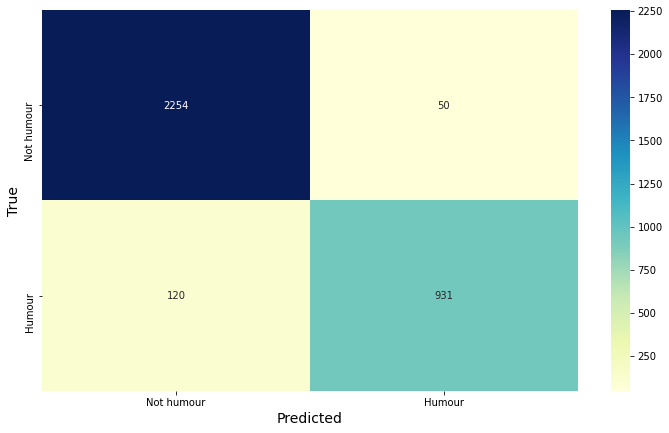

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

classes = ["Not humour", "Humour"]

df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))

sn.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel("Predicted", fontsize = 14)
plt.ylabel("True", fontsize = 14)
plt.savefig('output.png')

In [ ]:
def misclassifications(model, iterator):

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():

      #initialize lists for misclassification examples
      examples_nh = [] #misclassified as not humour
      examples_h = [] #misclassified as humour

      for i, batch in enumerate(iterator):
          data, labels = batch
          data = data.to(device)
          labels = labels.to(device)

          #get outputs and change into predictions
          outputs = model(data, labels=labels)
          y_pred = outputs.logits.cpu()
          pred = torch.argmax(y_pred, 1)
          
          #true labels
          y_true = labels.cpu()

          #get misclassifications per batch
          for item in range(len(pred)):
            if pred[item] != y_true[item]:
              if pred[item] == 1:
                # print("Misclassified as funny:", item)
                # print(X_test[item])
                examples_h.append(tokenizer.decode(data[item], 
                                                   skip_special_tokens = True))
              if pred[item] == 0:
                # print("Misclassified as not funny:", item)
                # print(X_test[item])
                examples_nh.append(tokenizer.decode(data[item], 
                                                    skip_special_tokens = True))
            else:
              continue

    return examples_nh, examples_h

In [ ]:
misclass_nh, misclass_h = misclassifications(model, test_loader)

print("MISCLASSIFIED AS NOT FUNNY:")
print("Number of sentences: ",len(misclass_nh))
for sentence in misclass_nh:
  print(sentence)

print(" ")
print("MISCLASSIFIED AS FUNNY:")
print("Number of sentences: ",len(misclass_h))
for sentence in misclass_h:
  print(sentence)